Use a GAN to generate ‘apparel’ based on MNIST fashion dataset.


1. Use keras to download the fashion MNIST dataset directly.


In [15]:
from tensorflow import keras

(X_train, y_train),(X_test,y_test) = keras.datasets.fashion_mnist.load_data()

print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

Training data shape: (60000, 28, 28)
Training labels shape: (60000,)
Test data shape: (10000, 28, 28)
Test labels shape: (10000,)


2. Visualize 25 apparel from the train dataset.

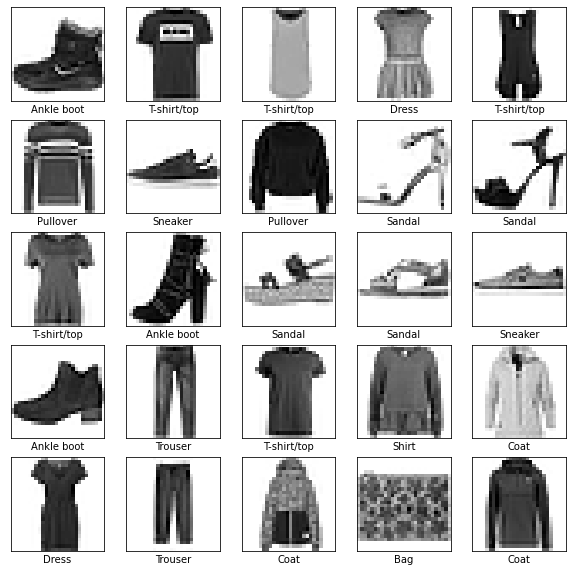

In [16]:
import matplotlib.pyplot as plt
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()


3. Flatten and scale the train and test images.


In [17]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
X_train = (X_train / 255. - 0.5) * 2
X_test = (X_test / 255. - 0.5) * 2

print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

Training data shape: (60000, 784)
Training labels shape: (60000,)
Test data shape: (10000, 784)
Test labels shape: (10000,)


4. Build the generator and discriminator networks.

In [18]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

def make_simple_gan(sample_size):
    K.clear_session()   # clear out old keras models that may be lurking

    generator = Sequential()
    generator.add(Input(shape=(sample_size,))) # sample size the number of random pixels from which we generate
    generator.add(Dense(128, activation=LeakyReLU(alpha=0.01)))
    generator.add(Dense(784, activation='tanh')) #tanh activation to limit output -1 to 1 to mimic input

    discriminator = Sequential()
    discriminator.add(Input(shape=(784,)))
    discriminator.add(Dense(128, activation=LeakyReLU(alpha=0.01)))
    discriminator.add(Dense(1, activation='sigmoid')) # sigmoid activation to limit output 0-1


    gan = Sequential([generator, discriminator])
    discriminator.compile(optimizer = Adam(learning_rate=0.001),loss = 'binary_crossentropy')
    gan.compile(optimizer = Adam(learning_rate=0.0001),  loss = 'binary_crossentropy')

    return gan, generator, discriminator



5. Choose appropriate hyperparameters.

In [19]:
sample_size = 100
epochs = 50
batch_size = 64
eval_size = 16
smooth = 0.1

6. Build the GAN network.

In [20]:
def make_latent_sample(n_samples, sample_size):
    return np.random.normal(loc = 0, scale = 1, size=(n_samples, sample_size))

def make_trainable(model, trainable):
    for layer in model.layers:
        layer.trainable = trainable

def make_labels(size):
    return np.ones([size, 1]), np.zeros([size, 1])

y_train_real, y_train_fake = make_labels(batch_size)
y_eval_real, y_eval_fake = make_labels(eval_size)

gan, generator, discriminator = make_simple_gan(sample_size)


7. Train the GAN network with at least 50 epochs.


In [21]:
losses = []
# loop through epochs
for e in range(epochs):
    for i in range(len(X_train)//batch_size):
        # Real images are sampled from mnist
        X_batch_real = X_train[i * batch_size: (i+1) * batch_size]


        # Start with random samples and then generate fake images
        latent_samples = make_latent_sample(batch_size, sample_size)
        X_batch_fake = generator.predict_on_batch(latent_samples)

        # Now train the discriminator to classify real from fake images
        # try to shuffle real and fake images and train the discriminator just once per batch
        # you try to train without the smooth factor
        make_trainable(discriminator, True)
        discriminator.train_on_batch(X_batch_real, y_train_real * (1 - smooth))
        discriminator.train_on_batch(X_batch_fake, y_train_fake)

        # now train the generator. Note that the generator is trained via the full GAN
        # before training, unfreeze the generator
        make_trainable(discriminator, False)
        make_trainable(generator, True)
        gan.train_on_batch(latent_samples, y_train_real)

    # Evaluate the overall progress
    X_eval_real = X_test[np.random.choice(len(X_test), eval_size, replace = False)]

    latent_samples = make_latent_sample(eval_size, sample_size)
    X_eval_fake = generator.predict_on_batch(latent_samples)

    # define loss function
    d_loss = discriminator.test_on_batch(X_eval_real, y_eval_real)
    d_loss = d_loss + discriminator.test_on_batch(X_eval_fake, y_eval_fake)

    # total gan loss
    # this is where label the generated images a 1.
    g_loss = gan.test_on_batch(latent_samples, y_eval_real)

    losses.append((d_loss, g_loss))

    print(e, d_loss, g_loss)



0 0.25388282537460327 2.9451308250427246
1 0.10674336925148964 3.283372640609741
2 0.09682054072618484 3.673403024673462
3 0.13321171700954437 2.76298189163208
4 0.19415771216154099 2.7017717361450195
5 0.19380677491426468 3.4066827297210693
6 0.13186761736869812 3.333002805709839
7 0.23868467658758163 3.1399192810058594
8 0.2479548156261444 3.1036953926086426
9 0.2160526067018509 2.49247145652771
10 0.15365388616919518 2.6559159755706787
11 0.14311418682336807 3.30472993850708
12 0.10335247963666916 2.8576877117156982
13 0.2164657637476921 2.6195459365844727
14 0.4409378468990326 2.55521821975708
15 0.3003067821264267 2.7792916297912598
16 0.2660454548895359 3.704340934753418
17 0.3628312945365906 3.4389781951904297
18 0.515825554728508 2.8119499683380127
19 0.2572649419307709 2.4227330684661865
20 0.31357400119304657 2.8279690742492676
21 0.38606712222099304 2.6593456268310547
22 0.21303589642047882 4.113739967346191
23 0.3872743397951126 2.264552354812622
24 0.5902395248413086 2.614

8. Plot the loss curves for the discriminator and generator.

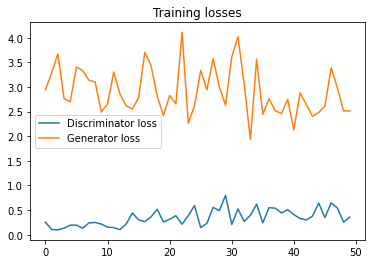

In [22]:
losses = np.array(losses)

plt.plot(losses[:, 0], label = 'Discriminator loss')
plt.plot(losses[:, 1], label = 'Generator loss')
plt.title('Training losses')
plt.legend()

9. After the GAN is trained, generate and visualize 64 apparels.

4/4 [==============================] - 0s 1ms/step


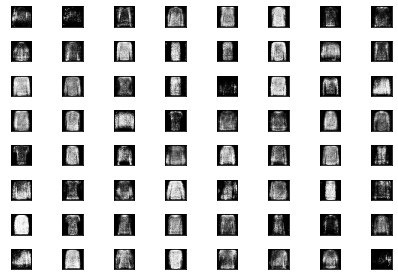

In [23]:
latent_samples = make_latent_sample(100, sample_size)
generated_images = generator.predict(latent_samples)

for i in range(64):
    img = generated_images[i]
    # unscaling the pixel values
    img = (img / 2 + 1) * 255
    img = img.reshape(28, 28)
    plt.subplot(8, 8, i + 1)
    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

10. Comment on the generative quality of these fashion items!

It appears that the images are generated in good shape, clear enough that we can tell roughly what category they are. but the actual content is very blurry, and there are no details in these images. In onlucsion, our GAN is able to generate rough images of these fashion items. 